In [98]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from itertools import chain
from skimage.io import imread, imshow
import sklearn.model_selection as skl
from random import sample 

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [99]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3765,00018464_013.png,No Finding,13,18464,058Y,F,AP,2500,2048,0.168,0.168
3865,00019045_003.png,Infiltration,3,19045,013M,F,PA,1562,1001,0.143,0.143
5007,00026466_002.png,No Finding,2,26466,039Y,M,PA,3056,2544,0.139,0.139


In [100]:
## Read full image filepaths into a samples dataframe for easier manipulation
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2859,00014149_007.png,Infiltration,7,14149,059Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00014149_007.png
1376,00007133_008.png,Atelectasis|Infiltration,8,7133,050Y,M,AP,2500,2048,0.171,0.171,/data/images_004/images/00007133_008.png
4299,00021201_027.png,Infiltration,27,21201,065Y,M,AP,3056,2544,0.139,0.139,/data/images_010/images/00021201_027.png


### Visualize metadata to inform model training

Distributions of diseases and comorbidities in dataset

In [101]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [102]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [103]:
num_with_pneumonia = all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')].shape[0]
num_without_pneumonia = all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia') == False].shape[0]

print(f"Num with Pneumonia: {num_with_pneumonia}")
print(f"Num without Pneumonia: {num_without_pneumonia}")
print(f"Fraction: {num_with_pneumonia / num_without_pneumonia}")

assert(num_with_pneumonia+num_without_pneumonia == len(all_xray_df))

Num with Pneumonia: 1431
Num without Pneumonia: 110689
Fraction: 0.012928113904724047


In [104]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
print(f"Labels [{len(all_labels)} total]: {all_labels}")

Labels [15 total]: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


[Text(0, 0.5, 'Number of Images with Label')]

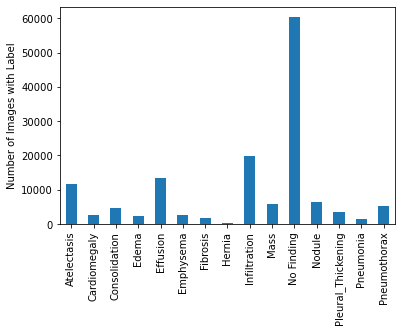

In [106]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The training set will need to be equally split between pneumonia and non-pneumonia findings, however there are not that many cases of Pneumonia in this very large dataset. This means that our actual training and validation sets used during training will be much smaller than the original NIH dataset.

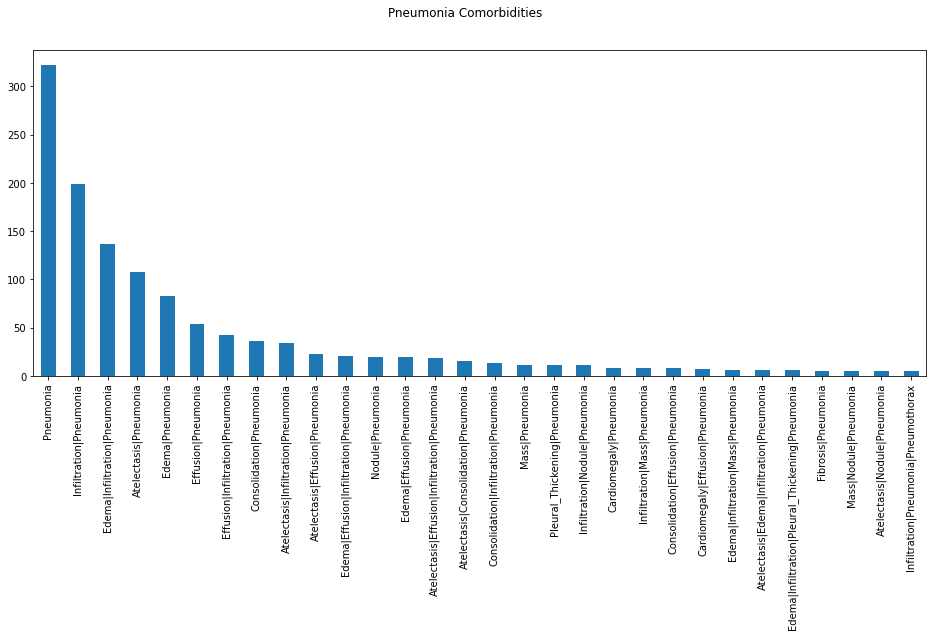

In [107]:
# 30 most common co-occurrences:
fig = plt.figure(figsize=(16,6))
fig.suptitle('Pneumonia Comorbidities')

# Alternative w/ str parsing
all_xray_df[all_xray_df['Finding Labels'].str.contains('Pneumonia')]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.show()

Pneumonia has many common commorbidities, mainly Infiltraion and Edema. These may be included in the model training, because we are trying to predict any occurance of pneumonia.

Distributions of basic demographics of the patients in dataset (age, gender, patient position)

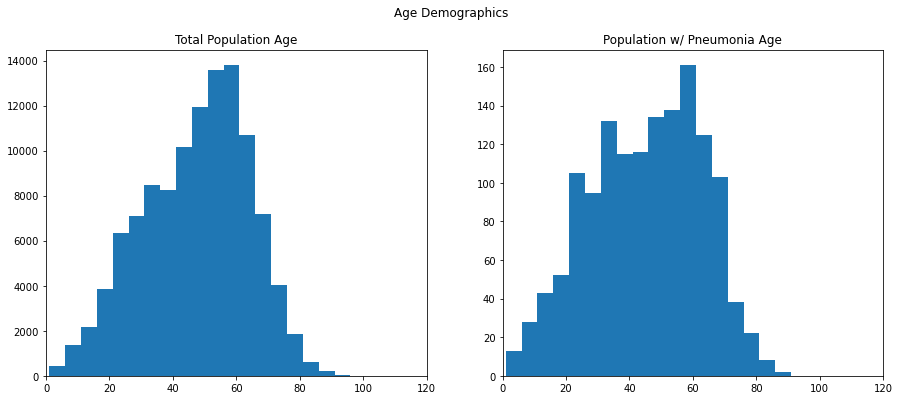

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Age Demographics')

bin_list = range(min(all_xray_df['Patient Age']), max(all_xray_df['Patient Age']) + 5, 5)

ax1.hist(all_xray_df['Patient Age'], bins=bin_list)
ax1.set_title("Total Population Age")
ax1.set_xlim([0, 120])

ax2.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=bin_list)
ax2.set_title("Population w/ Pneumonia Age")
ax2.set_xlim([0, 120])

plt.show()

Population with Penumonia has additional data in 25-30 an 35-40 age range, however it still follows roughly the same population curve.

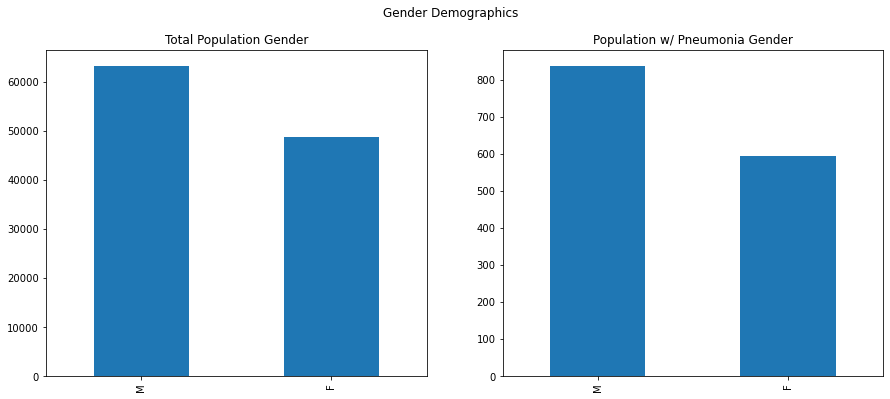

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Gender Demographics')

ax1.set_title("Total Population Gender")
all_xray_df['Patient Gender'].value_counts().plot(kind='bar', ax = ax1)

ax2.set_title("Population w/ Pneumonia Gender")
ax2 = all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar', ax = ax2)

plt.show()

Gender demographics are similar between total population and population with Pneumonia, so we will not stratify based on gender.

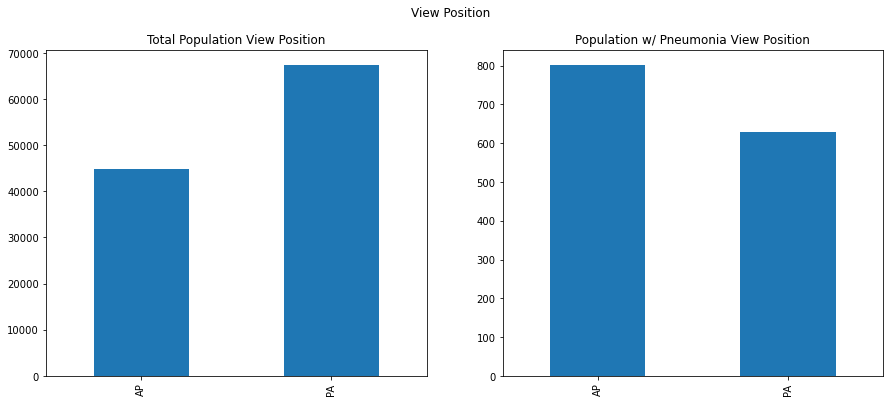

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('View Position')

ax1.set_title("Total Population View Position")
all_xray_df['View Position'].value_counts().reindex(["AP", "PA"]).plot(kind='bar', ax = ax1)

ax2.set_title("Population w/ Pneumonia View Position")
ax2 = all_xray_df[all_xray_df.Pneumonia==1]['View Position'].value_counts().reindex(["AP", "PA"]).plot(kind='bar', ax = ax2)

plt.show()

PA is more common in the total population, while AP is more common in population with Pneumonia. There are still many samples of each view position, and since the model will be trained with image augmentation, preservering the exact balance of view position in the training dataset will not be necessary.

### Preparing Dataset (Not necessary for this notebook)

In [38]:
train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])

In [39]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [40]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

In [43]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds)) # Equal number of indices w/ and w/o pneumonia
train_df = train_df.loc[p_inds + np_sample]

In [44]:
print(train_df['Pneumonia'].sum()/len(train_df))
print(train_df.shape)

0.5
(2290, 27)


#### Include 20% positive cases in validation set
We assume that the rate of pneumonia is higher in clinical setting where scan is required.

In [48]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [49]:
print(valid_df['Pneumonia'].sum()/len(valid_df))
print(valid_df.shape)

0.2
(335, 27)


In [50]:
print(num_with_pneumonia)

1431


### Relevant properties of pixel-level data

In [112]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3057,00015069_000.png,Infiltration|Pneumonia,0,15069,025Y,M,PA,2048,2500,0.168,0.168,/data/images_007/images/00015069_000.png
3403,00016786_001.png,Infiltration|Pneumonia,1,16786,023Y,F,AP,3056,2544,0.139,0.139,/data/images_008/images/00016786_001.png
3404,00016786_005.png,Infiltration|Pneumonia,5,16786,023Y,F,AP,3056,2544,0.139,0.139,/data/images_008/images/00016786_005.png
4411,00021818_026.png,Consolidation|Pneumonia,26,21818,037Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00021818_026.png
4581,00022870_004.png,Atelectasis|Pneumonia,4,22870,063Y,M,AP,3056,2544,0.139,0.139,/data/images_010/images/00022870_004.png


Samples With Pneumonia and First Listed Comorbidities


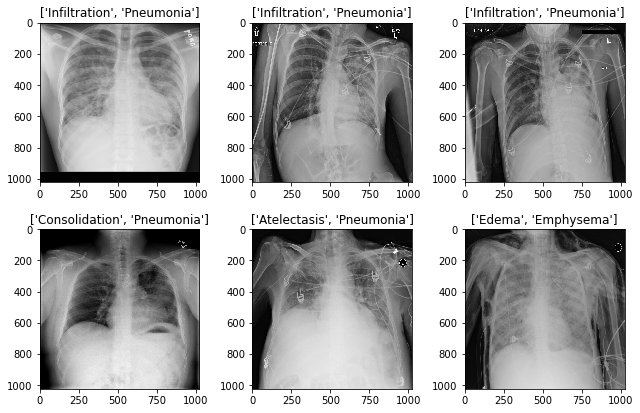

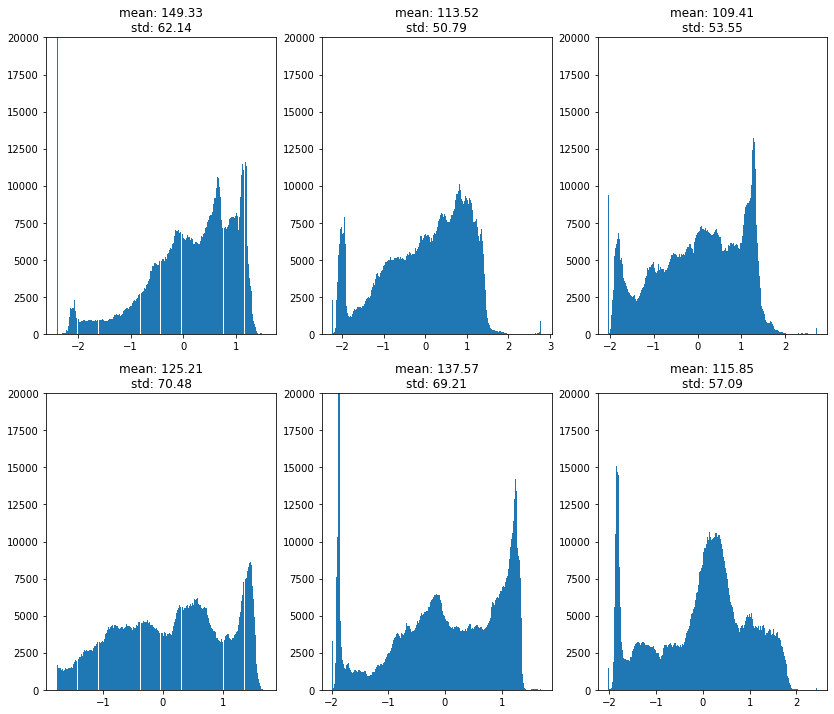

In [117]:
sample_with_pneumonia = sample_df[sample_df['Finding Labels'].str.contains("Pneumonia")].sample(6, random_state = 0)
display(sample_with_pneumonia.head())

print("Samples With Pneumonia and First Listed Comorbidities")

plt.figure(figsize=(9,6))
for i in range(1, 7):
    plt.subplot(2,3,i); imshow(sample_with_pneumonia.path.iloc[i-1])
    plt.title(sample_with_pneumonia['Finding Labels'].iloc[i-1].split('|')[0:2])
plt.show()
    
plt.figure(figsize=(14,12))
for i in range(1, 7):
    img = imread(sample_with_pneumonia.path.iloc[i-1])
    
    # Normalize and plot intensity values
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    normalized_img = img.copy()
    normalized_img = (normalized_img - mean_intensity)/std_intensity
    
    plt.subplot(2,3,i);
    plt.hist(normalized_img.ravel(), bins = 256)
    plt.ylim([0, 20000])
    plt.title(f"mean: {mean_intensity:.2f}\nstd: {std_intensity:.2f}")
plt.show()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
15,00000096_006.png,Effusion,6,96,067Y,F,PA,2242,2546,0.143000,0.143000,/data/images_001/images/00000096_006.png
350,00001855_023.png,Atelectasis|Infiltration|Pleural_Thickening,23,1855,013Y,M,AP,2500,2048,0.168000,0.168000,/data/images_002/images/00001855_023.png
3483,00017138_110.png,Infiltration,110,17138,024Y,M,AP,2500,2048,0.168000,0.168000,/data/images_008/images/00017138_110.png
5231,00028044_005.png,No Finding,5,28044,029Y,F,PA,1736,2021,0.194311,0.194311,/data/images_011/images/00028044_005.png
4195,00020623_000.png,No Finding,0,20623,072Y,M,PA,2658,2472,0.143000,0.143000,/data/images_009/images/00020623_000.png


Samples without Pneumonia and First Listed Findings


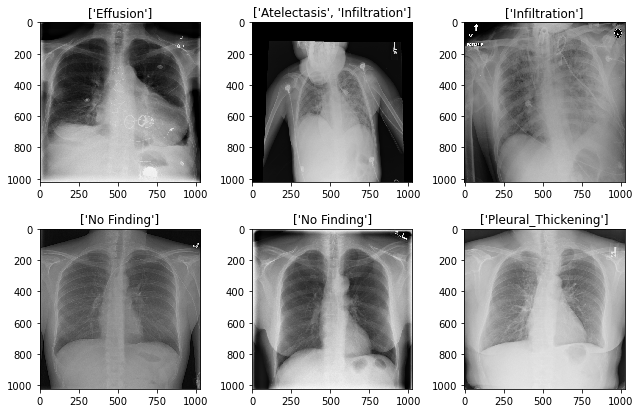

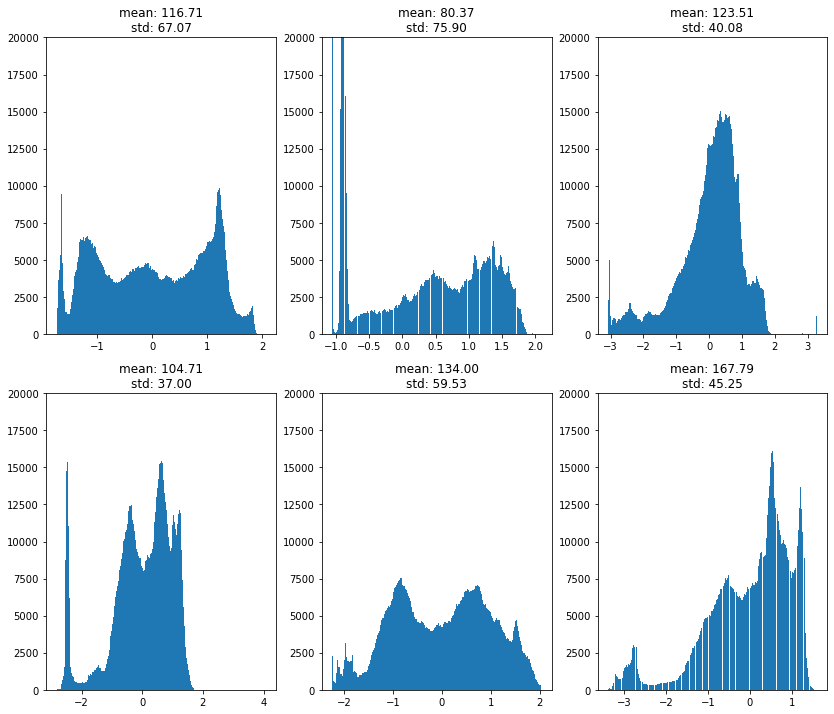

In [116]:
sample_without_pneumonia = sample_df[sample_df['Finding Labels'].str.contains("Pneumonia") == False].sample(6, random_state = 0)
display(sample_without_pneumonia.head())

print("Samples without Pneumonia and First Listed Findings")

plt.figure(figsize=(9,6))
for i in range(1, 7):
    plt.subplot(2,3,i); imshow(sample_without_pneumonia.path.iloc[i-1])
    plt.title(sample_without_pneumonia['Finding Labels'].iloc[i-1].split('|')[0:2])
plt.show()

plt.figure(figsize=(14,12))
for i in range(1, 7):
    img = imread(sample_without_pneumonia.path.iloc[i-1])
    
    # Normalize and plot intensity values
    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    normalized_img = img.copy()
    normalized_img = (normalized_img - mean_intensity)/std_intensity
    
    plt.subplot(2,3,i);
    plt.hist(normalized_img.ravel(), bins = 256)
    plt.ylim([0, 20000])
    plt.title(f"mean: {mean_intensity:.2f}\nstd: {std_intensity:.2f}")
plt.show()

The intensity histograms are not very consistent, so thresholding the identify Pneumonia would likely not be effective. We also see that for most images, the black border strongly effects the intensity statistics and produces a peak at the left side of the chart.

To address these issues, we may apply data augmentation to the training dataset including random cropping, zoom, shear, and saturation transformations.